In [ ]:
''' 
APS Failure and Operational Data for Scania Trucks has been downloaded from this page: 
https://archive.ics.uci.edu/dataset/421/aps+failure+at+scania+trucks
data cleaning has been performed with different Imputation methods
APS Failure at Scania Trucks has been modelled with different ML boosting techniques 
'''

In [255]:
#!pip install imblearn catboost xgboost

In [312]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix,classification_report, ConfusionMatrixDisplay


In [288]:
df_train=pd.read_csv("./data/aps_failure_training_set.csv",na_values="na")
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [289]:
print(df_train.shape)
df_train.columns

(60000, 171)


Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

<Axes: xlabel='class', ylabel='count'>

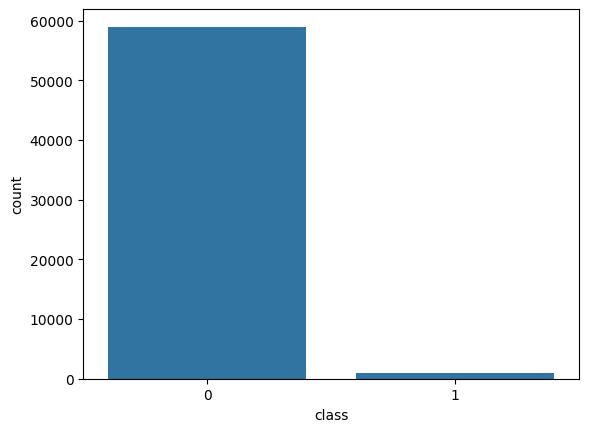

In [290]:
df_train['class'].unique()
df_train['class'].value_counts()
df_train['class']=df_train['class'].replace(['neg','pos'],[0,1])
sns.barplot(df_train['class'].value_counts())

In [291]:
df_train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
class,60000.0,2.000000e-02,1.300000e-01,0.0,0.0,0.0,0.0,1.000000e+00
aa_000,60000.0,5.933650e+04,1.454301e+05,0.0,834.0,30776.0,48668.0,2.746564e+06
ab_000,13671.0,7.100000e-01,3.480000e+00,0.0,0.0,0.0,0.0,2.040000e+02
ac_000,56665.0,3.560143e+08,7.948749e+08,0.0,16.0,152.0,964.0,2.130707e+09
ad_000,45139.0,1.906206e+05,4.040441e+07,0.0,24.0,126.0,430.0,8.584298e+09
...,...,...,...,...,...,...,...,...
ee_007,59329.0,3.462714e+05,1.728056e+06,0.0,110.0,41098.0,167814.0,1.195801e+08
ee_008,59329.0,1.387300e+05,4.495100e+05,0.0,0.0,3812.0,139724.0,1.926740e+07
ee_009,59329.0,8.388910e+03,4.747043e+04,0.0,0.0,0.0,2028.0,3.810078e+06
ef_000,57276.0,9.000000e-02,4.370000e+00,0.0,0.0,0.0,0.0,4.820000e+02


In [292]:
for col in df_train.columns:
    df_std=df_train[col].std()
    if df_std==0:
        print(col)

df_train.drop(columns="cd_000", inplace=True)

cd_000


In [293]:
y_train=df_train["class"]
X_train=df_train.drop(columns="class",axis=1)

# Treating Missing Values 

In [295]:
X_train.isnull().sum().values

array([    0, 46329,  3335, 14861,  2500,  2500,   671,   671,   671,
         671,   671,   671,   671,   671,   671,   671,   645,   629,
         629,  4400,   642,   629,   642,   589,   642,   589,  2723,
         629,   629,   629,  2500,  2501,   671,   671,   671,   671,
         671,   671,   671,   671,   671,   671,   671,   671,   671,
         671,   671,   671,   671,   671,   671,   671,   688,   688,
         688,   688,   688,   688,   688,   688,   688,   688,   645,
        2725,  2727,  2503,  2500,   642,   642,   589,   589, 23034,
       27277, 39549, 44009, 46333, 47740, 48722, 49264,   726,   167,
         691,   691,  3257,   473,  2723,  4356,   726,  3255,  2502,
       14861, 14861, 14861,   338,   338,   338,  9553,  9877,   687,
         687,   687,   687,   687,   687,   687,   687,   687,   687,
       14861,  2724,   691, 46329,   669,   669,   669,   669,   669,
         669,   669,   669,   669,   669, 13808, 13808, 13808, 13808,
       13808, 13808,

<BarContainer object of 169 artists>

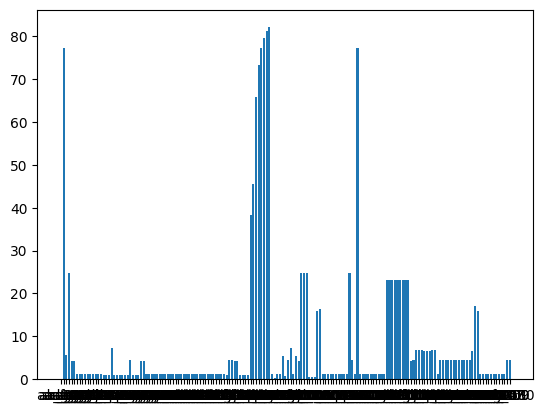

In [296]:
missing=(X_train.isna().sum().values/X_train.shape[0])*100
plt.bar(X_train.columns,missing)

In [297]:
drop_col=[]
fill_model=[]
fill_median=[]


for col in X_train.columns:
    if X_train[col].isna().sum()*100/X_train.shape[0] > 70:
        drop_col.append(col)
    elif X_train[col].isna().sum()*100/X_train.shape[0] > 20:
        fill_model.append(col)
    elif  X_train[col].isna().sum()*100/X_train.shape[0] < 20:
        fill_median.append(col)
    else:
        print(col)

# Drop columns having missing values > 70%

In [298]:
# Drop columns having missing values > 70%
X_train.drop(columns=drop_col, inplace=True)

In [ ]:
X_train.isna().sum().values.sum()*100/(X_train.shape[0]*X_train.shape[1])

# Fill columns having missing values <20% with Simple Imputer (median)

In [302]:
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.NaN,strategy='median')),
    ('RobustScaler', RobustScaler())
])
X_train[fill_median] = median_pipeline.fit_transform(X_train[fill_median])

In [304]:
X_train.isna().sum().values.sum()*100/(X_train.shape[0]*X_train.shape[1])

2.9674588477366255

# Fill the rest of missing vlaues with KNN model Imputer

**Imputation:** The KNNImputer imputes any missing values in your dataset using the k-nearest neighbors approach.
**Scaling:** The RobustScaler then scales the imputed data, making the features more robust to outliers.

In [305]:
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('RobustScaler', RobustScaler())
])
X_train[fill_model] = knn_pipeline.fit_transform(X_train[fill_model])

In [306]:
X_train.isna().sum().values.sum()*100/(X_train.shape[0]*X_train.shape[1])

0.0

# Handling Imbalanced Dataset

**SMOTETomek** is one of such a hybrid technique that aims to clean overlapping data points for each of the class distributed in sample space.
1. **SMOTE:** This technique generates synthetic samples for the minority class by interpolating between existing samples.
2. **Tomek Links:** This technique removes examples from the majority class that are very close to examples from the minority class, thus cleaning up the class boundary.

In [307]:
smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)
X_train_blanced, y_train_blanced = smt.fit_resample(X_train, y_train)

/usr/local/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [309]:
print(y_train_blanced.value_counts())
X_train_blanced.shape

class
0    58861
1    58861
Name: count, dtype: int64


(117722, 162)

# Train with different  machine learning models

In [311]:
models = {
    "RandomForest" : RandomForestClassifier(),
    "GradientBoosting" : GradientBoostingClassifier(),
    "XGBClassifier" : XGBClassifier(),
    "CatBoostClassifier" : CatBoostClassifier(verbose=False),
    "AdaBoostClassifier" : AdaBoostClassifier()
}

In [313]:
def evaluate_clf(actual, predicted):
    acc=accuracy_score(actual, predicted)
    f1=f1_score(actual, predicted)
    precision=precision_score(actual, predicted)
    recall=recall_score(actual, predicted)
    roc_auc=roc_auc_score(actual, predicted)
    tn, fp, fn, tp =confusion_matrix(actual, predicted).ravel()
    cost = 10*fp + 500*fn

    return acc, f1, precision, recall, roc_auc, cost

In [320]:
def model_eval(X,y,models):
    results=[]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
    for name, model in models.items():
        model.fit(X_train, y_train)
        ypred_train = model.predict(X_train)
        ypred_test = model.predict(X_test)
        
        train_acc, train_f1, train_precision, train_recall, train_roc_auc,train_cost= evaluate_clf(y_train, ypred_train)
        
        test_acc, test_f1, test_precision, test_recall, test_roc_auc,test_cost = evaluate_clf(y_test, ypred_test)
        
        results.append({
            'Model_Name': name,
            'Train_Accuracy': train_acc,
            'Train_F1': train_f1,
            'Train_Precision': train_precision,
            'Train_Recall': train_recall,
            'Train_ROC_AUC': train_roc_auc,
            'Train_Cost': train_cost,
            'Test_Accuracy': test_acc,
            'Test_F1': test_f1,
            'Test_Precision': test_precision,
            'Test_Recall': test_recall,
            'Test_ROC_AUC': test_roc_auc,
            'Test_Cost': test_cost
        })
        
    report = pd.DataFrame(results)#.sort_values(by=['Test_Cost'])
    return report

In [321]:
model_eval(X_train_blanced, y_train_blanced,models)

,Model_Name,Train_Accuracy,Train_F1,Train_Precision,Train_Recall,Train_ROC_AUC,Train_Cost,Test_Accuracy,Test_F1,Test_Precision,Test_Recall,Test_ROC_AUC,Test_Cost
0,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0,0.994818,0.994863,0.992773,0.996962,0.994804,18860
1,GradientBoosting,0.984773,0.984807,0.981024,0.988620,0.984780,276490,0.983903,0.984063,0.980640,0.987509,0.983880,76310
2,XGBClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0,0.997239,0.997261,0.995709,0.998818,0.997229,7510
3,CatBoostClassifier,0.999512,0.999511,0.999553,0.999468,0.999511,12710,0.996050,0.996083,0.994282,0.997890,0.996038,13180
4,AdaBoostClassifier,0.977330,0.977317,0.976290,0.978346,0.977332,520170,0.976131,0.976311,0.975242,0.977382,0.976123,136940
